## Costa Rican Household Poverty Level Prediction

Going to data analysis about 'Costa Rican Household Poverty Level Prediction' dataset.

Followed the Will Koehrsen and YouHan Lee kernels of the datsset, great thanks to two contributers for sharing the kernels.

* **Will Koerhsen_A Complete Introduction and Walkthrough :** [**URL**](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough/notebook)

* **YouHan Lee_3250feats->532 feats using shap[LB: 0.436] :** [**URL**](https://www.kaggle.com/youhanlee/3250feats-532-feats-using-shap-lb-0-436#1.-Check-datasets)
---------------------------------------------

Welcome to another Kaggle challenge! The objective of the Costa Rican Household Poverty Level Prediction contest is to develop a machine learning model that can predict the poverty level of households using both individual and household characteristics. This "data science for good" project offers the opportunity to put our skills towards a task more beneficial to society than getting people to click on ads!

In this notebook, we will walk through a complete machine learning solution: first, get introduced to the problem, then perform a thorough Exploratory Data Analysis of the dataset, work on feature engineering, try out multiple machine learning models, select a model, work to optimize the model, and finally, inspect the outputs of the model and draw conclusions. __While this notebook may not get us to the top of the leaderboard, it is meant to be used as a teaching tool to give you a solid foundation to build on for future machine learning projects. Kaggle projects can teach us a lot about machine learning, but several of the strategies used to get to the very top of the leaderboard are not best practices, so here we'll stick to building a very good - although not quite first place - machine learning solution. While Kaggle projects are competitions, I think they are best described as "a machine learning education" disguised as a contest!"

If you are looking to follow-up on this work, I have additional work including a [kernel on using Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/featuretools-for-good) with [Featuretools](https://featuretools.alteryx.com/en/stable/#minute-quick-start) for this problem (with slightly higher leaderboard score). (If you enjoy my writing style and explanations, I write for [Towards Data Science](https://williamkoehrsen.medium.com/)

### Problem and Data Explanation

The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. **Each row represents one individual and each column is a feature, either unique to the individual, or for the household of the individual.** The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty.

**This is a supervised multi-class classification machine learning problem:**

* Supervised: provided with the labels for the training data
* Multi-class classification: Labels are discrete values with 4 classes

### Objective

The objective is to predict poverty on a **household level.** We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis.

**Important note: while all members of a household should have the same label in the training data, there are errors where individuals in the same household have different labels. In these cases, we are told to use the label for the head of each household, which can be identified by the rows where parentesco1 == 1.0.**

We will cover how to correct this in the notebook.

The Target values represent poverty levels as follows:

* 1 = extreme poverty 
* 2 = moderate poverty 
* 3 = vulnerable households 
* 4 = non vulnerable households

The explanations for all 143 columns can be found in the competition documentation, but a few to note are below:

* Id: a unique identifier for each individual, this should not be a feature that we use!
* idhogar: a unique identifier for each household. This variable is not a feature, but will be used to group individuals by household as all individuals in a household will have the same identifier.
* parentesco1: indicates if this person is the head of the household.
* Target: the label, which should be equal for all members in a household

When we make a model, we'll train on a household basis with the label for each household the poverty level of the head of household. 

The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with no head of household which means that unfortunately we can't use this data for training. 
These issues with the data are completely typical of real-world data and hence this problem is great preparation for the datasets you'll encounter in a data science job!

### Metric

Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Our predictions will be assessed by the **Macro F1 Score.** You may be familiar with the [standard F1 score](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) for binary classification problems which is the harmonic mean of precision and recall:

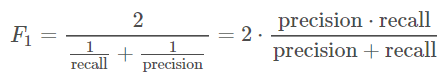
 
For mutli-class problems, we have to average the F1 scores for each class. The macro F1 score averages the F1 score for each class without taking into account label imbalances.

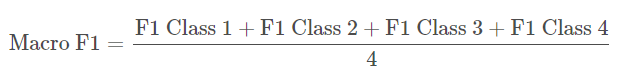

In other words, the number of occurrences of each label does not figure into the calculation when using macro (while it does when using the "weighted" score). If we want to assess our performance, we can use the code:

* from sklearn.metrics import f1_score
* f1_score(y_true, y_predicted, average = 'macro`)

For this problem, the labels are imbalanced, which makes it a little strange to use macro averaging for the evaluation metric, but that's a decision made by the organizers and not something we can change! In your own work, you want to be aware of label imbalances and choose a metric accordingly.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
# 용이한 반복 기능을 적용하는 모듈: https://hamait.tistory.com/803
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from tqdm import tqdm
import featuretools as ft
import warnings
warnings.filterwarnings('ignore')
import time

## 1. Check datasets

### 1.1 Read dataset

In [ ]:
df_train = pd.read_csv('../input/costa-rican-household-poverty-prediction/train.csv')
df_test = pd.read_csv('../input/costa-rican-household-poverty-prediction/test.csv')

In [ ]:
print('df_train_shape: ', df_train.shape, ' ', 'df_test_shape', df_test.shape)

### 1.2 Make description of

In [ ]:
description = [
("v2a1"," Monthly rent payment"),
("hacdor"," =1 Overcrowding by bedrooms"),
("rooms","  number of all rooms in the house"),
("hacapo"," =1 Overcrowding by rooms"),
("v14a"," =1 has toilet in the household"),
("refrig"," =1 if the household has refrigerator"),
("v18q"," owns a tablet"),
("v18q1"," number of tablets household owns"),
("r4h1"," Males younger than 12 years of age"),
("r4h2"," Males 12 years of age and older"),
("r4h3"," Total males in the household"),
("r4m1"," Females younger than 12 years of age"),
("r4m2"," Females 12 years of age and older"),
("r4m3"," Total females in the household"),
("r4t1"," persons younger than 12 years of age"),
("r4t2"," persons 12 years of age and older"),
("r4t3"," Total persons in the household"),
("tamhog"," size of the household"),
("tamviv"," number of persons living in the household"),
("escolari"," years of schooling"),
("rez_esc"," Years behind in school"),
("hhsize"," household size"),
("paredblolad"," =1 if predominant material on the outside wall is block or brick"),
("paredzocalo"," =1 if predominant material on the outside wall is socket (wood, zinc or absbesto"),
("paredpreb"," =1 if predominant material on the outside wall is prefabricated or cement"),
("pareddes"," =1 if predominant material on the outside wall is waste material"),
("paredmad"," =1 if predominant material on the outside wall is wood"),
("paredzinc"," =1 if predominant material on the outside wall is zink"),
("paredfibras"," =1 if predominant material on the outside wall is natural fibers"),
("paredother"," =1 if predominant material on the outside wall is other"),
("pisomoscer"," =1 if predominant material on the floor is mosaic ceramic   terrazo"),
("pisocemento"," =1 if predominant material on the floor is cement"),
("pisoother"," =1 if predominant material on the floor is other"),
("pisonatur"," =1 if predominant material on the floor is  natural material"),
("pisonotiene"," =1 if no floor at the household"),
("pisomadera"," =1 if predominant material on the floor is wood"),
("techozinc"," =1 if predominant material on the roof is metal foil or zink"),
("techoentrepiso"," =1 if predominant material on the roof is fiber cement,   mezzanine "),
("techocane"," =1 if predominant material on the roof is natural fibers"),
("techootro"," =1 if predominant material on the roof is other"),
("cielorazo"," =1 if the house has ceiling"),
("abastaguadentro"," =1 if water provision inside the dwelling"),
("abastaguafuera"," =1 if water provision outside the dwelling"),
("abastaguano"," =1 if no water provision"),
("public"," =1 electricity from CNFL,  ICE, ESPH/JASEC"),
("planpri"," =1 electricity from private plant"),
("noelec"," =1 no electricity in the dwelling"),
("coopele"," =1 electricity from cooperative"),
("sanitario1"," =1 no toilet in the dwelling"),
("sanitario2"," =1 toilet connected to sewer or cesspool"),
("sanitario3"," =1 toilet connected to  septic tank"),
("sanitario5"," =1 toilet connected to black hole or letrine"),
("sanitario6"," =1 toilet connected to other system"),
("energcocinar1"," =1 no main source of energy used for cooking (no kitchen)"),
("energcocinar2"," =1 main source of energy used for cooking electricity"),
("energcocinar3"," =1 main source of energy used for cooking gas"),
("energcocinar4"," =1 main source of energy used for cooking wood charcoal"),
("elimbasu1"," =1 if rubbish disposal mainly by tanker truck"),
("elimbasu2"," =1 if rubbish disposal mainly by botan hollow or buried"),
("elimbasu3"," =1 if rubbish disposal mainly by burning"),
("elimbasu4"," =1 if rubbish disposal mainly by throwing in an unoccupied space"),
("elimbasu5"," =1 if rubbish disposal mainly by throwing in river,   creek or sea"),
("elimbasu6"," =1 if rubbish disposal mainly other"),
("epared1"," =1 if walls are bad"),
("epared2"," =1 if walls are regular"),
("epared3"," =1 if walls are good"),
("etecho1"," =1 if roof are bad"),
("etecho2"," =1 if roof are regular"),
("etecho3"," =1 if roof are good"),
("eviv1"," =1 if floor are bad"),
("eviv2"," =1 if floor are regular"),
("eviv3"," =1 if floor are good"),
("dis"," =1 if disable person"),
("male"," =1 if male"),
("female"," =1 if female"),
("estadocivil1"," =1 if less than 10 years old"),
("estadocivil2"," =1 if free or coupled uunion"),
("estadocivil3"," =1 if married"),
("estadocivil4"," =1 if divorced"),
("estadocivil5"," =1 if separated"),
("estadocivil6"," =1 if widow/er"),
("estadocivil7"," =1 if single"),
("parentesco1"," =1 if household head"),
("parentesco2"," =1 if spouse/partner"),
("parentesco3"," =1 if son/doughter"),
("parentesco4"," =1 if stepson/doughter"),
("parentesco5"," =1 if son/doughter in law"),
("parentesco6"," =1 if grandson/doughter"),
("parentesco7"," =1 if mother/father"),
("parentesco8"," =1 if father/mother in law"),
("parentesco9"," =1 if brother/sister"),
("parentesco10"," =1 if brother/sister in law"),
("parentesco11"," =1 if other family member"),
("parentesco12"," =1 if other non family member"),
("idhogar"," Household level identifier"),
("hogar_nin"," Number of children 0 to 19 in household"),
("hogar_adul"," Number of adults in household"),
("hogar_mayor"," # of individuals 65+ in the household"),
("hogar_total"," # of total individuals in the household"),
("dependency"," Dependency rate"),
("edjefe"," years of education of male head of household"),
("edjefa"," years of education of female head of household"),
("meaneduc","average years of education for adults (18+)"),
("instlevel1"," =1 no level of education"),
("instlevel2"," =1 incomplete primary"),
("instlevel3"," =1 complete primary"),
("instlevel4"," =1 incomplete academic secondary level"),
("instlevel5"," =1 complete academic secondary level"),
("instlevel6"," =1 incomplete technical secondary level"),
("instlevel7"," =1 complete technical secondary level"),
("instlevel8"," =1 undergraduate and higher education"),
("instlevel9"," =1 postgraduate higher education"),
("bedrooms"," number of bedrooms"),
("overcrowding"," # persons per room"),
("tipovivi1"," =1 own and fully paid house"),
("tipovivi2"," =1 own,   paying in installments"),
("tipovivi3"," =1 rented"),
("tipovivi4"," =1 precarious"),
("tipovivi5"," =1 other(assigned"),
("computer"," =1 if the household has notebook or desktop computer,   borrowed)"),
("television"," =1 if the household has TV"),
("mobilephone"," =1 if mobile phone"),
("qmobilephone"," # of mobile phones"),
("lugar1"," =1 region Central"),
("lugar2"," =1 region Chorotega"),
("lugar3"," =1 region PacÃƒÂ­fico central"),
("lugar4"," =1 region Brunca"),
("lugar5"," =1 region Huetar AtlÃƒÂ¡ntica"),
("lugar6"," =1 region Huetar Norte"),
("area1"," =1 zona urbana"),
("area2"," =2 zona rural"),
("age"," Age in years"),
("SQBescolari"," escolari squared"),
("SQBage"," age squared"),
("SQBhogar_total"," hogar_total squared"),
("SQBedjefe"," edjefe squared"),
("SQBhogar_nin"," hogar_nin squared"),
("SQBovercrowding"," overcrowding squared"),
("SQBdependency"," dependency squared"),
("SQBmeaned"," meaned squared"),
("agesq"," Age squared"),]

description = pd.DataFrame(description, columns=['varname', 'description'])

In [ ]:
description.head()

### 1.3 Check Null data

In [ ]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis = 1, keys=['Total','Percent'])

missing_df.head(20)

### 1.4 Fill Missing Values

* Below cell is from this kernel

#### url: https://www.kaggle.com/skooch/lgbm-w-random-split-2

In [ ]:
# if education is 'yes' and person is head of household, fill with escolari

df_train.loc[(df_train['edjefa'] == 'yes') & (df_train['parentesco1'] ==1), 'edjefa'] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what 'yes' means, let's fill it with 4
df_train.loc[df_train['edjefa']=='yes', 'edjefa'] = 4
df_train.loc[df_train['edjefe']=='yes', 'edjefe'] = 4

df_test.loc[df_test['edjefa']== 'yes', 'edjefa'] = 4
df_test.loc[df_test['edjefe']== 'yes', 'edjefe'] = 4

# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis = 1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet,
# if there is no water we'll assume they do not
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

### rez_esz, SQBmeaned

* rez_esc : Years behind in school >> filled with 0
* SQBmeaned : Square of the mean years of education of adults (>=18) in the household agesq, Age squared >> same with rez_esc >> filled with 0

In [ ]:
df_train['rez_esc'].fillna(0, inplace =True)
df_test['rez_esc'].fillna(0, inplace =True)

In [ ]:
df_train['SQBmeaned'].fillna(0, inplace =True)
df_test['SQBmeaned'].fillna(0, inplace =True)

### meaneduc

* meaneduc: average years of education for adults (18+) >> filled with 0

In [ ]:
df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

#### v18q1

* v18q1 : number of tablets household owns >> if v18q (do you own a tablet?) == 1, there are some values. If not, only NaN values in v18q1.

In [ ]:
df_train['v18q'].value_counts()

In [ ]:
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

In [ ]:
df_train.loc[df_train['v18q'] == 0, 'v18q1'].value_counts()

In [ ]:
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

* v2a1: number of tablets household owns -> if tipovivi3(rented?) == 1, there are some values. If not, there are also some values.

* NaN value could be replaced by 0.

In [ ]:
df_train['tipovivi3'].value_counts()

In [ ]:
plt.figure(figsize = (10,6))

sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'],
           label = 'Monthly rent payment of household(rented =1)', color = 'red')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 0, 'v2a1'],
           label = 'Monthly rent payment of household(rented =0)', color = 'blue')
plt.xscale('log');
plt.legend(loc='upper right');
plt.show();

In [ ]:
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [ ]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending = False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(4)

In [ ]:
total = df_test.isnull().sum().sort_values(ascending = False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending = False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(4)

## 2. Feature engineering

### 2.1 Object featrues

In [ ]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']

In [ ]:
features_object

#### Dependency

In [ ]:
# some dependencies as Na, fill those with the square root of the square
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

#### edjefe

* edjefe : years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes ==1 and no == 0
* replace yes >> 1 and no >> 0

In [ ]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
    
df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

#### edjefa

* edjefa : years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes ==1 and no == 0
* replace yes >> 1 and no >> 0

In [ ]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
    
df_train['edjefa'] = df_train['edjefe'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefe'].apply(replace_edjefa).astype(float)

In [ ]:
# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis = 1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis = 1)

#### roof and electricity

In [ ]:
df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan

df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso']== 0) and (x['techocane'] ==0) and (x['techootro'] == 0):
        return 1
    else: 
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0
    
df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x), axis=1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x), axis=1)

df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x), axis=1)
df_test['electricity_other'] = df_test.apply(lambda x : fill_no_electricity(x), axis=1)

### 2.2 Extract cat features

* According to data scripts, there are many binary category features.

In [ ]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]

### 2.3 Make new features using continuous feature

In [ ]:
continuous_features = [col for col in df_train.columns if col not in binary_cat_features]
continuous_features = [col for col in continuous_features if col not in features_object]
continuous_features = [col for col in continuous_features if col not in ['Id', 'Target', 'idhogar']]

In [ ]:
print('there are {} continuous featrues'.format(len(continuous_features)))
for col in continuous_features:
    print('{}: {}'.format(col, description.loc[description['varname'] == col, 
                                              'description'].values))

* hhsize : household size
* tamhog : size of the household
> What is different?

* As you can see, the meaning of two features are same but the exact number are different. Are they different?
* I don't know. For now, I decided to drop one feature 'tamhog'.

In [ ]:
df_train['edjef'].value_counts()

In [ ]:
df_train.drop('tamhog', axis=1, inplace=True)
df_test.drop('tamhog', axis=1, inplace=True)

#### Squared features

* There are many squared features. Acually, tree models like lightgbm don't need them. But at this kernel, want to use lighthbm as filter model and set entity-embedding as classifier. So let's keep them.

### Family features

* hogar_nin, hogar_adul, hogar_mayor, hogar_total, r4h1, r4h2, r4h3, r4m1, r4m2, r4m3, r4t1, r4t2, r4t3, tmbhog, tamvid, rez_esc, escolari

* Family size features (subtract, ratio)

In [ ]:
df_train['adult'] = df_train['hogar_adul'] - df_train['hogar_mayor']
df_train['dependency_count'] = df_train['hogar_nin'] + df_train['hogar_mayor']
df_train['dependency'] = df_train['dependency_count'] / df_train['adult']
df_train['child_percent'] = df_train['hogar_nin'] / df_train['hogar_total']
df_train['elder_percent'] = df_train['hogar_mayor'] / df_train['hogar_total']
df_train['adult_percent'] = df_train['hogar_adul'] / df_train['hogar_total']
df_train['males_younger_12_years_percent'] = df_train['r4h1'] / df_train['hogar_total']
df_train['males_older_12_years_percent'] = df_train['r4h2'] / df_train['hogar_total']
df_train['males_percent'] = df_train['r4h3'] / df_train['hogar_total']
df_train['females_younger_12_years_percent'] = df_train['r4m1'] / df_train['hogar_total']
df_train['females_older_12_years_percent'] = df_train['r4m2'] / df_train['hogar_total']
df_train['females_percent'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_percent'] = df_train['r4t1'] / df_train['hogar_total']
df_train['persons_older_12_years_percent'] = df_train['r4t2'] / df_train['hogar_total']
df_train['persons_percent'] = df_train['r4t3'] / df_train['hogar_total']

In [ ]:
df_test['adult'] = df_test['hogar_adul'] - df_test['hogar_mayor']
df_test['dependency_count'] = df_test['hogar_nin'] + df_test['hogar_mayor']
df_test['dependency'] = df_test['dependency_count'] / df_test['adult']
df_test['child_percent'] = df_test['hogar_nin'] / df_test['hogar_total']
df_test['elder_percent'] = df_test['hogar_mayor'] / df_test['hogar_total']
df_test['adult_percent'] = df_test['hogar_adul'] / df_test['hogar_total']
df_test['males_younger_12_years_percent'] = df_test['r4h1'] / df_test['hogar_total']
df_test['males_older_12_years_percent'] = df_test['r4h2'] / df_test['hogar_total']
df_test['males_percent'] = df_test['r4h3'] / df_test['hogar_total']
df_test['females_younger_12_years_percent'] = df_test['r4m1'] / df_test['hogar_total']
df_test['females_older_12_years_percent'] = df_test['r4m2'] / df_test['hogar_total']
df_test['females_percent'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_percent'] = df_test['r4t1'] / df_test['hogar_total']
df_test['persons_older_12_years_percent'] = df_test['r4t2'] / df_test['hogar_total']
df_test['persons_percent'] = df_test['r4t3'] / df_test['hogar_total']

In [ ]:
df_train['males_younger_12_years_in_household_size'] = df_train['r4h1'] / df_train['hhsize']
df_train['males_older_12_years_in_household_size'] = df_train['r4h2'] / df_train['hhsize']
df_train['males_in_household_size'] = df_train['r4h3'] / df_train['hhsize']
df_train['females_younger_12_years_in_household_size'] = df_train['r4m1'] / df_train['hhsize']
df_train['females_older_12_years_in_household_size'] = df_train['r4m2'] / df_train['hhsize']
df_train['females_in_household_size'] = df_train['r4m3'] / df_train['hogar_total']
df_train['persons_younger_12_years_in_household_size'] = df_train['r4t1'] / df_train['hhsize']
df_train['persons_older_12_years_in_household_size'] = df_train['r4t2'] / df_train['hhsize']
df_train['persons_in_household_size'] = df_train['r4t3'] / df_train['hhsize']

In [ ]:
df_test['males_younger_12_years_in_household_size'] = df_test['r4h1'] / df_test['hhsize']
df_test['males_older_12_years_in_household_size'] = df_test['r4h2'] / df_test['hhsize']
df_test['males_in_household_size'] = df_test['r4h3'] / df_test['hhsize']
df_test['females_younger_12_years_in_household_size'] = df_test['r4m1'] / df_test['hhsize']
df_test['females_older_12_years_in_household_size'] = df_test['r4m2'] / df_test['hhsize']
df_test['females_in_household_size'] = df_test['r4m3'] / df_test['hogar_total']
df_test['persons_younger_12_years_in_household_size'] = df_test['r4t1'] / df_test['hhsize']
df_test['persons_older_12_years_in_household_size'] = df_test['r4t2'] / df_test['hhsize']
df_test['persons_in_household_size'] = df_test['r4t3'] / df_test['hhsize']

In [ ]:
df_train['overcrowding_room_and_bedroom'] = (df_train['hacdor'] + df_train['hacapo'])/2
df_test['overcrowding_room_and_bedroom'] = (df_test['hacdor'] + df_test['hacapo'])/2

In [ ]:
df_train['escolari_age'] = df_train['escolari']/df_train['age']
df_test['escolari_age'] = df_test['escolari']/df_test['age']

df_train['age_12_19'] = df_train['hogar_nin'] - df_train['r4t1']
df_test['age_12_19'] = df_test['hogar_nin'] - df_test['r4t1']  

In [ ]:
df_train['phones-per-capita'] = df_train['qmobilephone'] / df_train['tamviv']
df_train['tablets-per-capita'] = df_train['v18q1'] / df_train['tamviv']
df_train['rooms-per-capita'] = df_train['rooms'] / df_train['tamviv']
df_train['rent-per-capita'] = df_train['v2a1'] / df_train['tamviv']

In [ ]:
df_test['phones-per-capita'] = df_test['qmobilephone'] / df_test['tamviv']
df_test['tablets-per-capita'] = df_test['v18q1'] / df_test['tamviv']
df_test['rooms-per-capita'] = df_test['rooms'] / df_test['tamviv']
df_test['rent-per-capita'] = df_test['v2a1'] / df_test['tamviv']

In [ ]:
(df_train['hogar_total'] == df_train['r4t3']).sum()

### preprocessing for family features
#### 'v2a1', 'rooms', 'bedrooms', 'v18q1', 'qmobilephone', 'rez_esc'


* I will reduce the number of features using shape, so let's generate many features.

In [ ]:
feature_lst = ['v2a1', 'rooms', 'bedrooms', 'v18q1', 'qmobilephone', 'rez_esc']
family_size_features = ['adult', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'hogar_total', 'r4h1', 
                        'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'hhsize']
new_feats = [] 

for f in feature_lst:
    new_feats = []
    for col in family_size_features:
        new_col_name = 'new_{}_per_{}'.format(f, col)
        new_feats.append(new_col_name)
        df_train[new_col_name] = df_train[f] / df_train[col]
        df_test[new_col_name] = df_test[f] / df_test[col]

    for feat in new_feats:
        df_train[feat].replace([np.inf], np.nan, inplace = True)
        df_train[feat].fillna(0, inplace = True)

        df_test[feat].replace([np.inf], np.nan, inplace = True)
        df_test[feat].fillna(0, inplace = True)      

In [ ]:
df_train['rez_esc_age'] = df_train['rez_esc'] / df_train['age']
df_train['rez_esc_escolari'] = df_train['rez_esc'] / df_train['escolari']

df_test['rez_esc_age'] = df_test['rez_esc'] / df_test['age']
df_test['rez_esc_escolari'] = df_test['rez_esc'] / df_test['escolari']

In [ ]:
print(df_train.shape, df_test.shape)

### Rich features

* I think the more richer, the larger number of phones and tabulet

In [ ]:
df_train['tabulet_x_qmobilephone'] = df_train['v18q1'] * df_train['qmobilephone']
df_test['tabulet_x_qmobilephone'] = df_test['v18q1'] * df_test['qmobilephone']

* wall, roof, floor may be key factor.
* Let's multiply each of them. Becuase they are binary cat features, so mulitification of each features generates new categorical features

In [ ]:
# wall and roof
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
# wall and floor
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

# roof and floor
for col1 in ['etecho1', 'etecho2', 'etecho3']:
    for col2 in ['eviv1', 'eviv2', 'eviv3']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

* combination using three features

In [ ]:
for col1 in ['epared1', 'epared2', 'epared3']:
    for col2 in ['etecho1', 'etecho2', 'etecho3']:
        for col3 in ['eviv1', 'eviv2', 'eviv3']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [ ]:
print(df_train.shape, df_test.shape)

* I want to mix electricity and energy features >> energy features

In [ ]:
for col1 in ['public', 'planpri', 'noelec', 'coopele']:
    for col2 in ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

* I want to mix toilet and rubbish disposal features >> other_infra features

In [ ]:
for col1 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
    for col2 in ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

* I want to mix toilet and water provision features >> water features

In [ ]:
for col1 in ['abastaguadentro', 'abastaguafuera', 'abastaguano']:
    for col2 in ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

In [ ]:
print(df_train.shape, df_test.shape)

* I want to mix education and area features >> education_zone_features

In [ ]:
for col1 in ['area1', 'area2']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

* Mix region and education

In [ ]:
for col1 in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    for col2 in ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

In [ ]:
print(df_train.shape, df_test.shape)

* Multiply television, mobilephone, computer, tabulet, refrigerator >> electronics features

In [ ]:
df_train['electronics'] = df_train['computer'] * df_train['mobilephone'] * df_train['television'] * df_train['v18q'] * df_train['refrig']
df_test['electronics'] = df_test['computer'] * df_test['mobilephone'] * df_test['television'] * df_test['v18q'] * df_test['refrig']

df_train['no_appliances'] = df_train['refrig'] + df_train['computer'] + df_train['television'] + df_train['mobilephone']
df_test['no_appliances'] = df_test['refrig'] + df_test['computer'] + df_test['television'] + df_test['mobilephone']

* Mix wall matereial of root, florr, wall

In [ ]:
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]

for col1 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
        new_col_name = 'new_{}_x_{}'.format(col1, col2)
        df_train[new_col_name] = df_train[col1] * df_train[col2]
        df_test[new_col_name] = df_test[col1] * df_test[col2]        
        
for col1 in ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']:
    for col2 in ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']:
        for col3 in ['techozinc', 'techoentrepiso', 'techocane', 'techootro']:
            new_col_name = 'new_{}_x_{}_x_{}'.format(col1, col2, col3)
            df_train[new_col_name] = df_train[col1] * df_train[col2] * df_train[col3]
            df_test[new_col_name] = df_test[col1] * df_test[col2] * df_train[col3]

In [ ]:
print(df_train.shape, df_test.shape)

#### Remove feature with only one value

In [ ]:
cols_with_only_one_value = []
for col in df_train.columns :
    if col == 'Target':
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] ==1 :
        print(col)
        cols_with_only_one_value.append(col)

In [ ]:
df_train.drop(cols_with_only_one_value, axis = 1, inplace = True)
df_test.drop(cols_with_only_one_value, axis = 1, inplace = True)

#### Check whether both train and test have same features

In [ ]:
cols_train = np.array(sorted([col for col in df_train.columns if col != 'Target']))
cols_test = np.array(sorted(df_test.columns))

In [ ]:
(cols_train == cols_test).sum() == len(cols_train)

### 2.4 Aggregation features

* In this competition, each samples are member of specific household(idhogar). So let's aggregate based on 'idhogar' values.

In [ ]:
def max_min(x):
    return x.max() - x.min()

* Enumerate : 
1. 반복문 사용 시 몇 번째 반복문인지 확인이 필요할 수 있습니다. 이때 사용합니다.
2. 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환합니다.
-------------------------

* Groupby, agg function:
1. url: https://rfriend.tistory.com/392

In [ ]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()

for item in tqdm(family_size_features):
    for i, function in enumerate(['mean', 'std', 'min', 'max', 'sum', 'count', max_min]):
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        
        if i == 6:
            new_col = item + '_new' + 'max_min'
        else: 
            new_col = item + '_new' + function
        
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test
        
print('new aggregate train set has {} row, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} row, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

In [ ]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']

for item in tqdm(aggr_list):
    for function in ['count', 'sum']:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        new_col = item + '_new' + function
        
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

In [ ]:
aggr_list = ['escolari', 'age', 'escolari_age', 'dependency', 'bedrooms', 'overcrowding', 'rooms', 'qmobilephone', 'v18q1']

for item in tqdm(aggr_list):
    for function in ['mean','std','min','max','sum', 'count', max_min]:
        group_train = df_train[item].groupby(df_train['idhogar']).agg(function)
        group_test = df_test[item].groupby(df_test['idhogar']).agg(function)
        if i == 6:
            new_col = item + '_new2_' + 'max_min'
        else:
            new_col = item + '_new2_' + function
        agg_train[new_col] = group_train
        agg_test[new_col] = group_test

print('new aggregate train set has {} rows, and {} features'.format(agg_train.shape[0], agg_train.shape[1]))
print('new aggregate test set has {} rows, and {} features'.format(agg_test.shape[0], agg_test.shape[1]))

In [ ]:
agg_test = agg_test.reset_index()
agg_train = agg_train.reset_index()

train_agg = pd.merge(df_train, agg_train, on='idhogar')
test = pd.merge(df_test, agg_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

print('train shape:', train_agg.shape, 'test shape:', test.shape)

In [ ]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
# dataframe indexing as "list + list" 
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new3_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

In [ ]:
aggr_list = ['rez_esc', 'dis', 'male', 'female', 
                  'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
                  'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
                  'parentesco11', 'parentesco12',
                  'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',
                 'epared1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'refrig', 'television', 'mobilephone',
            'area1', 'area2', 'v18q', 'edjef']
    
for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
    group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_train.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_train][2:]

    group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).sum().reset_index()
    group_test.columns = [lugar, 'idhogar'] + ['new4_{}_idhogar_{}'.format(lugar, col) for col in group_test][2:]

    train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
    test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
    
print('train shape:', train_agg.shape, 'test shape:', test.shape)

In [ ]:
cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

for function in tqdm(['mean','std','min','max','sum', 'count', max_min]):
    for lugar in ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']:
        group_train = df_train[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_train.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_train][2:]

        group_test = df_test[[lugar, 'idhogar'] + aggr_list].groupby([lugar, 'idhogar']).agg(function).reset_index()
        group_test.columns = [lugar, 'idhogar'] + ['new5_{}_idhogar_{}_{}'.format(lugar, col, function) for col in group_test][2:]

        train_agg = pd.merge(train_agg, group_train, on=[lugar, 'idhogar'])
        test = pd.merge(test, group_test, on=[lugar, 'idhogar'])
        
print('train shape:', train_agg.shape, 'test shape:', test.shape)

* According to data descriptions,ONLY the heads of household are used in scoring. /
* All household members are included in test + the sample submission, but only heads of households are scored.

In [ ]:
train = train_agg.query('parentesco1==1')

In [ ]:
train['dependency'].replace(np.inf, 0, inplace=True)
test['dependency'].replace(np.inf, 0, inplace=True)

In [ ]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id',  'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)

In [ ]:
print('final_data size', train.shape, test.shape)

In [ ]:
print(f'The most positive feature: \n{correlation.head()}')

In [ ]:
print(f'The most negative feature: \n{correlation.tail()}')

## 4. Feature selection using shap

In [ ]:
binary_cat_features = [col for col in train.columns if train[col].value_counts().shape[0] == 2]
object_features = ['edjefe', 'edjefa']

categorical_feats = binary_cat_features + object_features

In [ ]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [ ]:
y = train['Target']
train.drop(columns = ['Target'], inplace = True)

In [ ]:
def print_execution_time(start):
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('*'*20, "Execution ended in {:0>2}h {:0>2}m {:05.2f}s".format(int(hours),int(minutes),seconds), '*'*20)

#### lightGBM parameters

url : https://gorakgarak.tistory.com/1285

* max_depth : 나무의 깊이. 단일 결정나무에서는 충분히 데이터를 고려하기 위해 depth를 적당한 깊이로 만들지만, 부스팅에서는 깊이 하나짜리도 만드는 등, 깊이가 짧은것이 크리티컬하지 않다. 어차피 보정되니까..

* min_data_in_leaf : 한 잎사귀 노드에 들어갈수 있는 데이터의 갯수.

* feature_fraction : 부스팅 대상 모델이 랜덤포레스트일때, 랜덤포레스트는 feature의 일부만을 선택하여 훈련하는데, 이를 통제하기 위한 파라미터.

* bagging_fraction : 데이터의 일부만을 사용하는 bagging의 비율이다. 예를들어 오버피팅을 방지하기 위해 데이터의 일부만을 가져와서 훈련시키는데, 이는 오버피팅을 방지하며 약한예측기를 죄다 합칠경우는 오히려 예측성능이 좋아질것이다.

* early_stopping_round : 더이상 validation데이터에서 정확도가 좋아지지 않으면 멈춰버린다. 훈련데이터는 거의 에러율이 0에 가깝게 좋아지기 마련인데, validation데이터는 훈련에 사용되지 않기때문에 일정이상 좋아지지 않기 때문이다. 이후 진행하게 되면 컴퓨터 재능낭비다.

* lambda : 정규화에 사용되는 파라미터

* min_gain_to_split : 최소 정보이득이 있어야 분기가 되게끔 만든다.

* max_cat_group : 범주형 변수가 많으면, 하나로 퉁쳐서 처리하게끔 만드는 최소단위.

* objective : lightgbm은 regression, binary, multicalss 모두 가능

* boosting: gbdt(gradient boosting decision tree), rf(random forest), dart(dropouts meet multiple additive regression trees), goss(Gradient-based One-Side Sampling)

* num_leaves: 결정나무에 있을 수 있는 최대 잎사귀 수. 기본값은 0.31

* learning_rate : 상당히 중요한 파라미터인데, 각 예측기마다 얼마나 가중치를 주어 학습하게 할것인지 만든다. learning_rate은 아래의 num_boost_round와 잘 맞춰져야 ㅎ나다.

* num_boost_round : boosting을 얼마나 돌릴지 지정한다. 경험상 보통 100정도면 너무 빠르게 끝나며, 시험용이 아니면 1000정도는 준다. 어차피 early_stopping_round가 지정되어있으면 더이상 진전이 없을경우 알아서 멈춘다.

* device : gpu, cpu

* metric: loss를 측정하기 위한 기준. mae (mean absolute error), mse (mean squared error), 등등이 있다. 사실 엄청많다.

* max_bin : 최대 bin

* categorical_feature : 범주형 변수가 있을때 여기에 언급해준다. 다만, categorical은 string은 쓸수 없는것으로 보인다.

* ignore_column : 컬럼을 무시한다. 무시하지 않을경우 모두 training에 넣는데, 뭔가 남겨놓아야할 컬럼이 있으면 여기다가 인자를 준다.

* save_binary: True로 해놓으면 메모리를 아낀다.

In [ ]:
def extract_good_features_using_shap_LGB(params, SEED):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )

    kfold = 5
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    feat_importance_df  = pd.DataFrame()

    for i, (train_index, test_index) in enumerate(kf.split(train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb, categorical_feature=categorical_feats,
                early_stopping_rounds=100, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        print_execution_time(start)

    feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
#     feat_importance_df_shap['shap_cumsum'] = feat_importance_df_shap['shap_values'].cumsum() / feat_importance_df_shap['shap_values'].sum()
#     good_features = feat_importance_df_shap.loc[feat_importance_df_shap['shap_cumsum'] < 0.999].feature
    return feat_importance_df_shap

In [ ]:
total_shap_df  = pd.DataFrame()
NUM_ITERATIONS = 10
for SEED in range(NUM_ITERATIONS):
    print('#'*40, '{} of {} iterations'.format(SEED+1, NUM_ITERATIONS), '#' * 40)
    params = {'max_depth': np.random.choice([5, 6, 7, 8, 10, 12, -1]),
             'learning_rate': np.random.rand() * 0.02,
              'colsample_bytree': np.random.rand() * (1 - 0.5) + 0.5,
              'subsample': np.random.rand() * (1 - 0.5) + 0.5,
              'min_split_gain': np.random.rand() * 0.2,
              'num_leaves': np.random.choice([32, 48, 64]),
              'reg_alpha': np.random.rand() * 2,
              'reg_lambda': np.random.rand() *2,
              'bagging_freq': np.random.randint(4) +1,
              'min_child_weight': np.random.randint(100) + 20
             }
    temp_shap_df = extract_good_features_using_shap_LGB(params, SEED)
    total_shap_df = pd.concat([total_shap_df, temp_shap_df])

In [ ]:
shap_sorted_df = total_shap_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()
feat_imp_sorted_df = total_shap_df.groupby('feature').mean().sort_values('feat_imp', ascending=False).reset_index()
features_top_shap = shap_sorted_df['feature'][:500]
features_top_feat_imp = feat_imp_sorted_df['feature'][:500]
top_features = pd.Series(features_top_shap.tolist() + features_top_feat_imp.tolist())
top_features = top_features.unique()

## 4. Model Development

In [ ]:
new_train = train[top_features].copy()
new_test = test[top_features].copy()

In [ ]:
print('new_train shape:', new_train.shape, 'new_test shape:', new_test.shape)

In [ ]:
new_categorical_feats = [col for col in top_features if col in categorical_feats]

In [ ]:
def LGB_OOF(params, categorical_feats, N_FOLDs, SEED=1989):
    clf = lgb.LGBMClassifier(objective='multiclass',
                             random_state=1989,
                             max_depth=params['max_depth'], 
                             learning_rate=params['learning_rate'],  
                             silent=True, 
                             metric='multi_logloss',
                             n_jobs=-1, n_estimators=10000, 
                             class_weight='balanced',
                             colsample_bytree = params['colsample_bytree'], 
                             min_split_gain= params['min_split_gain'], 
                             bagging_freq = params['bagging_freq'],
                             min_child_weight=params['min_child_weight'],
                             num_leaves = params['num_leaves'], 
                             subsample = params['subsample'],
                             reg_alpha= params['reg_alpha'],
                             reg_lambda= params['reg_lambda'],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED,
                            )

    kfold = 10
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    feat_importance_df  = pd.DataFrame()
    predicts_result = []

    for i, (train_index, test_index) in enumerate(kf.split(new_train, y)):
        print('='*30, '{} of {} folds'.format(i+1, kfold), '='*30)
        start = time.time()
        X_train, X_val = new_train.iloc[train_index], new_train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=evaluate_macroF1_lgb,categorical_feature=new_categorical_feats,
                early_stopping_rounds=100, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        fold_importance_df  = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df['feat_imp'] = clf.feature_importances_
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        predicts_result.append(clf.predict(new_test))
        print_execution_time(start)
    return predicts_result, feat_importance_df

In [ ]:
params = {'max_depth': 6,
         'learning_rate': 0.002,
          'colsample_bytree': 0.8,
          'subsample': 0.8,
          'min_split_gain': 0.02,
          'num_leaves': 48,
          'reg_alpha': 0.04,
          'reg_lambda': 0.073,
          'bagging_freq': 2,
          'min_child_weight': 40
         }

N_Folds = 20
SEED = 1989
predicts_result, feat_importance_df = LGB_OOF(params, new_categorical_feats, N_Folds, SEED=1989)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
feat_importance_df_shap = feat_importance_df.groupby('feature').mean().sort_values('shap_values', ascending=False).reset_index()

num_features = 50
sns.barplot(x=feat_importance_df_shap.shap_values[:num_features], y=feat_importance_df_shap.feature[:num_features], ax=ax[0])
ax[0].set_title('Feature importance based on shap values')

feat_importance_df = feat_importance_df.groupby('feature').mean().sort_values('feat_imp', ascending=False).reset_index()

num_features = 50
sns.barplot(x=feat_importance_df.shap_values[:num_features], y=feat_importance_df.feature[:num_features], ax=ax[1])
ax[1].set_title('Feaure importance based on feature importance from lgbm')
plt.show()

In [ ]:
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission.csv', index = False)

### Randomized Search

In [ ]:
optimized_param = None
lowest_cv = 1000
total_iteration = 50
for i in range(total_iteration):
    print('-'*20, 'For {} of {} iterations'.format(i+1, total_iteration), '-'*20)
    learning_rate = np.random.rand() * 0.02
    n_folds = 3

    num_class = len(np.unique(y))

    params = {}
    params['application'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = num_class
    params['class_weight'] = 'balanced'
    params['num_leaves'] = np.random.randint(24, 48)
    params['max_depth'] = np.random.randint(5, 8)
    params['min_child_weight'] = np.random.randint(5, 50)
    params['min_split_gain'] = np.random.rand() * 0.09
    params['colsample_bytree'] = np.random.rand() * (0.9 - 0.1) + 0.1
    params['subsample'] = np.random.rand() * (1 - 0.8) + 0.8
    params['bagging_freq'] = np.random.randint(1, 5)
    params['bagging_seed'] = np.random.randint(1, 5)
    params['reg_alpha'] = np.random.rand() * 2
    params['reg_lambda'] = np.random.rand() * 2
    params['learning_rate'] = np.random.rand() * 0.02
    params['seed']  =1989

    d_train = lgb.Dataset(data=new_train, label=y.values-1, categorical_feature=new_categorical_feats, free_raw_data=False)
    cv_results = lgb.cv(params=params, train_set=d_train, num_boost_round=10000, categorical_feature=new_categorical_feats,
                        nfold=n_folds, stratified=True, shuffle=True, early_stopping_rounds=1, verbose_eval=1000)

    min_cv_results = min(cv_results['multi_logloss-mean'])

    if min_cv_results < lowest_cv:
        lowest_cv = min_cv_results
        optimized_param = params

In [ ]:
N_Folds = 20
SEED = 1989
predicts_result, feat_importance_df = LGB_OOF(optimized_param, new_categorical_feats, N_Folds, SEED=1989)

In [ ]:
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission_shap_randomized_search.csv', index = False)